In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Load the cleaned data instead of the original
df = pd.read_csv('C:\\Users\\User\\Desktop\\machine_learning\\soils\\cleaned_MTRD_Soils_data.csv')

# No need for complex column cleaning anymore
# Display first few rows to confirm data structure
print("First 5 rows:")
print(df.head())

# Handle missing values if any
df = df.fillna(df.mean())

# Standardize numerical features - update column names
scaler = StandardScaler()
numerical_cols = [col for col in df.columns if col not in ['SampleNo.', 'Dosage.%']]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Select relevant soil properties - note the correctly named columns
soil_properties = df[[col for col in df.columns if 'SoilComposition' in col]]

# Print column names to debug
print("All columns:", df.columns.tolist())
print("Soil properties columns:", soil_properties.columns.tolist())

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['SoilClass'] = kmeans.fit_predict(soil_properties)

# Use the first two soil composition columns for the plot
soil_cols = soil_properties.columns.tolist()
if len(soil_cols) >= 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=soil_cols[0], y=soil_cols[1], hue='SoilClass', data=df)
    plt.title('Soil Clusters by Composition')
    plt.xlabel(soil_cols[0])
    plt.ylabel(soil_cols[1])
else:
    print("Not enough soil composition columns for plotting")

# Define features and target - update column names
X = df.drop(['CBR.4daysSoak.(%)'], axis=1)  # Use correct CBR column name
y = df['CBR.4daysSoak.(%)']  # Use correct CBR column name

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

# Feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 10 most important features
print("\nTop 10 most important features:")
print(importances.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(importances['Feature'][:10], importances['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()


First 5 rows:
   SampleNo.  Grading.%PassingBSSieveSize(mm).20  \
0          1                                 100   
1          2                                 100   
2          3                                 100   
3          4                                 100   
4          5                                 100   

   Grading.%PassingBSSieveSize(mm).10  Grading.%PassingBSSieveSize(mm).5  \
0                                  77                                 57   
1                                  78                                 60   
2                                 100                                 99   
3                                  89                                 76   
4                                  84                                 67   

   Grading.%PassingBSSieveSize(mm).2  Grading.%PassingBSSieveSize(mm).0.425  \
0                                 44                                     29   
1                                 49                      

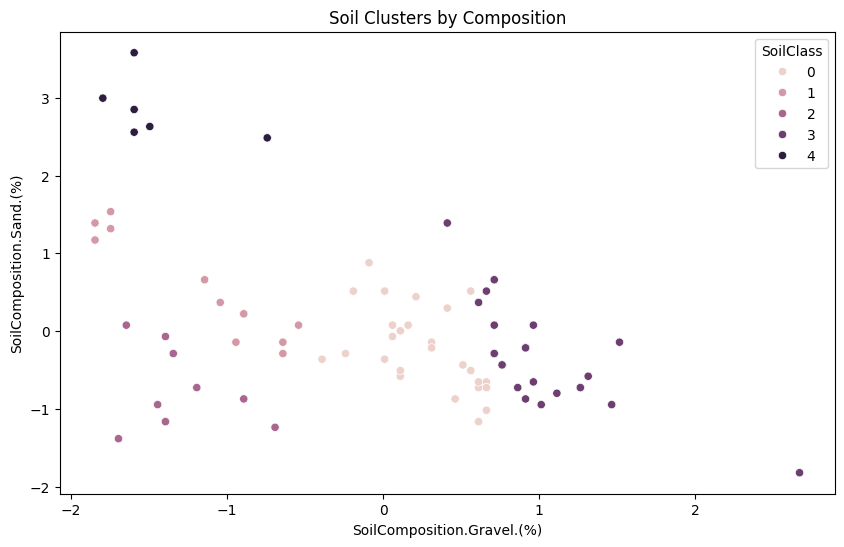

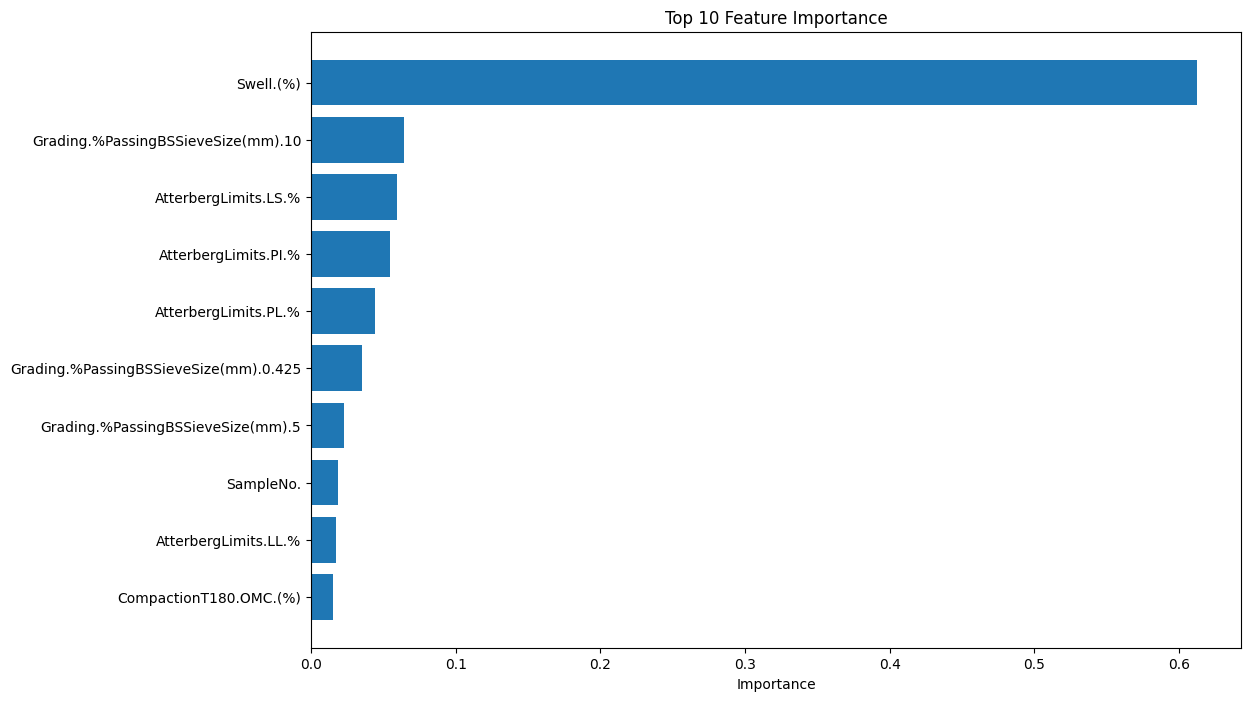

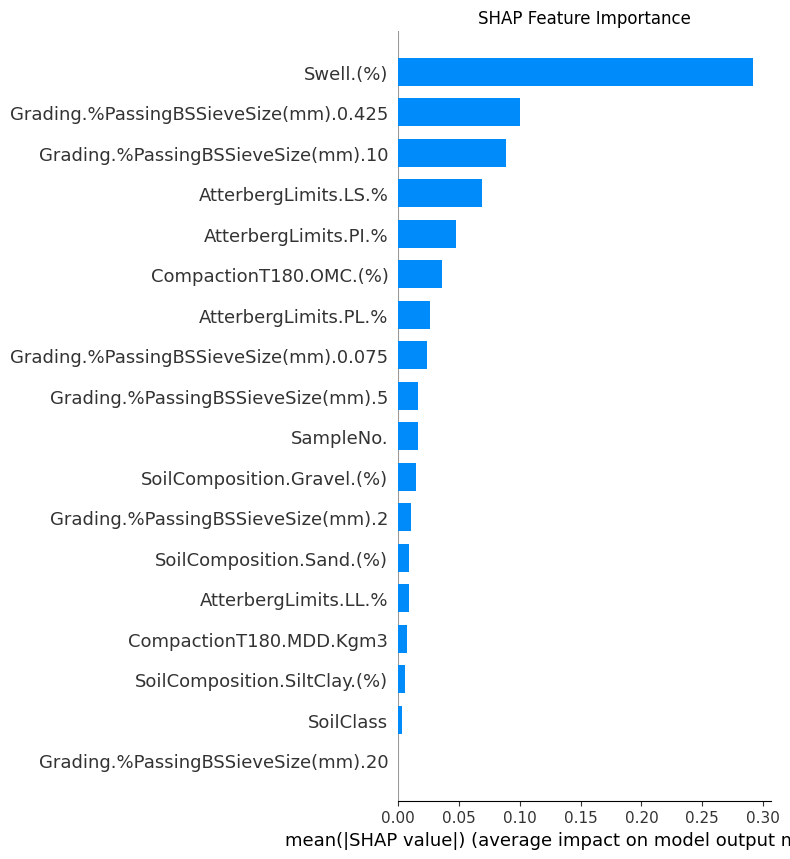

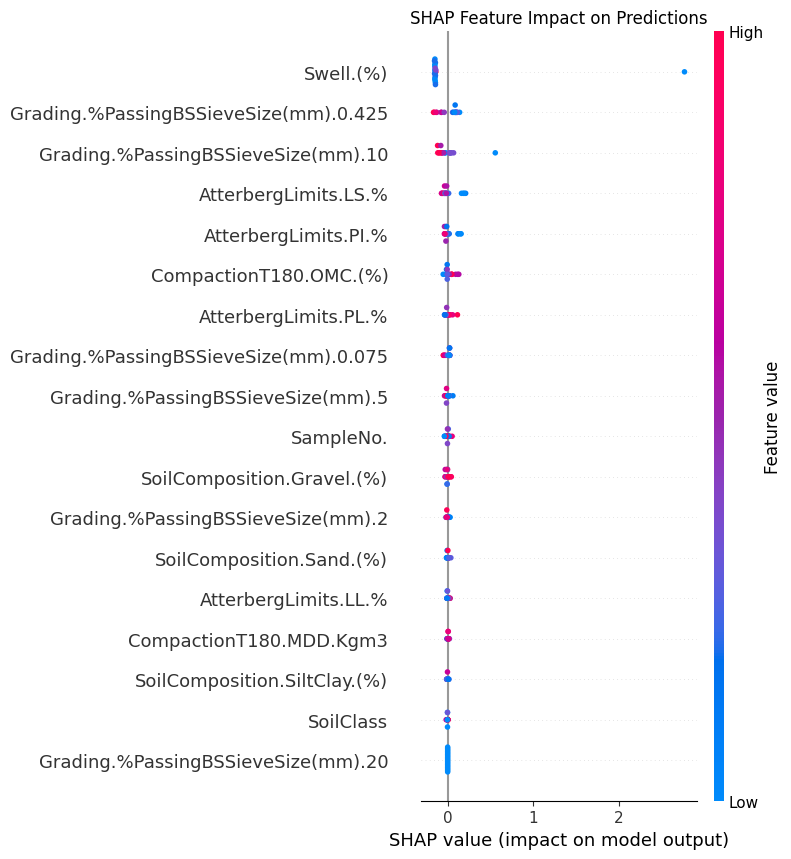

<Figure size 1000x600 with 0 Axes>

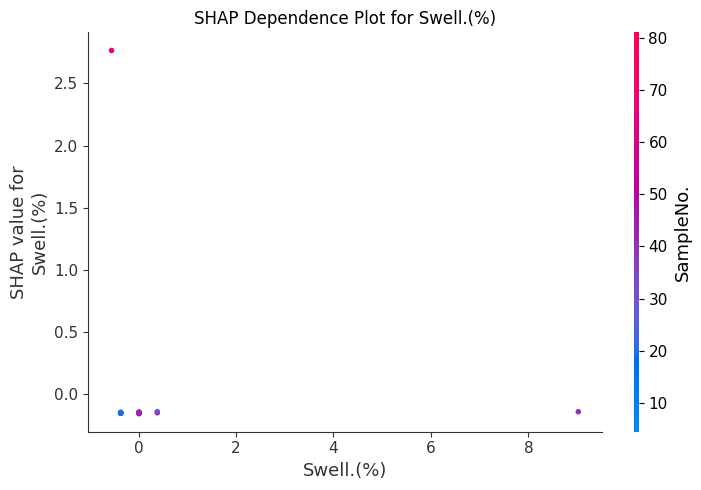

<Figure size 2000x300 with 0 Axes>

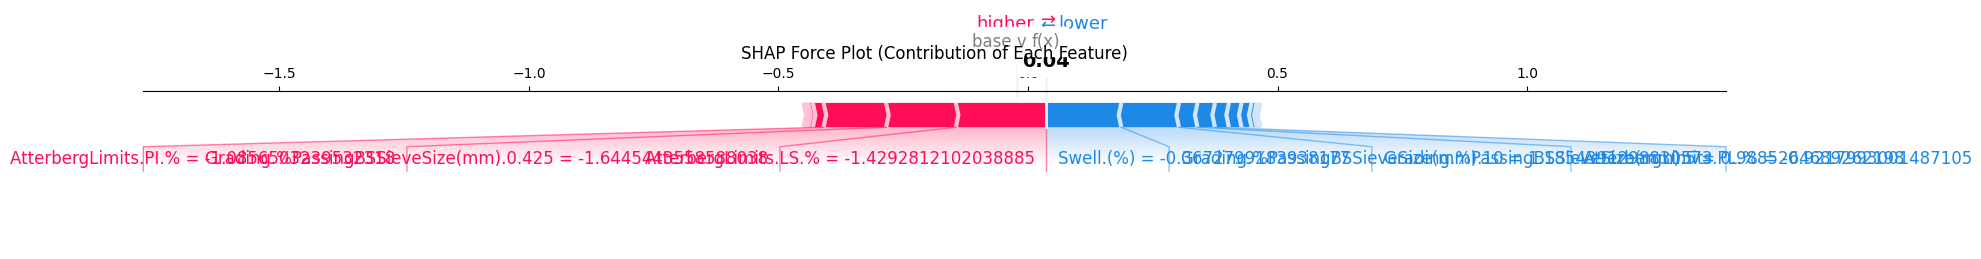

In [24]:
# Import SHAP
import shap

# Create a new cell for SHAP analysis
# Create a SHAP explainer for the RandomForest model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set (use a smaller sample if dataset is large)
sample_size = min(100, X_test.shape[0])  # Use at most 100 samples for speed
sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_sample = X_test.iloc[sample_indices]

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Create a summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Create a detailed SHAP summary plot with individual feature impacts
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Feature Impact on Predictions")
plt.tight_layout()
plt.show()

# Display individual feature dependence plot for the most important feature
most_important_feature = importances['Feature'].iloc[0]
plt.figure(figsize=(10, 6))
shap.dependence_plot(most_important_feature, shap_values, X_sample, show=False)
plt.title(f"SHAP Dependence Plot for {most_important_feature}")
plt.tight_layout()
plt.show()

# Create a force plot for a single prediction
sample_idx = 0
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, 
                shap_values[sample_idx,:], 
                X_sample.iloc[sample_idx,:], 
                matplotlib=True,
                show=False)
plt.title("SHAP Force Plot (Contribution of Each Feature)")
plt.tight_layout()
plt.show()

In [25]:
#remove swell from features and retrain model
X_no_swell = X.drop(['Swell.(%)'], axis=1)
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_no_swell, y, test_size=0.2, random_state=42)
rf_model_nd = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_nd.fit(X_train_nd, y_train_nd)     

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
# Evaluate without swell
y_pred_no_swell = rf_model_nd.predict(X_test_nd)
print("Model Performance WITHOUT Swell:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_no_swell))}")
print(f"R²: {r2_score(y_test, y_pred_no_swell)}")


Model Performance WITHOUT Swell:
RMSE: 0.5548187274817917
R²: 0.636500531739683


In [27]:
# Feature importance without swell
importances_no_swell = pd.DataFrame({
    'Feature': X_no_swell.columns,
    'Importance': rf_model_nd.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 features WITHOUT swell:")
print(importances_no_swell.head(10))


Top 10 features WITHOUT swell:
                                  Feature  Importance
9                    AtterbergLimits.PI.%    0.192304
2      Grading.%PassingBSSieveSize(mm).10    0.179315
10                   AtterbergLimits.LS.%    0.175907
8                    AtterbergLimits.PL.%    0.112368
5   Grading.%PassingBSSieveSize(mm).0.425    0.053804
13             SoilComposition.Gravel.(%)    0.046865
0                               SampleNo.    0.039086
12                 CompactionT180.OMC.(%)    0.030246
7                    AtterbergLimits.LL.%    0.028822
11                CompactionT180.MDD.Kgm3    0.027601


C:\Users\User\AppData\Local\Temp\ipykernel_17508\3717616383.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


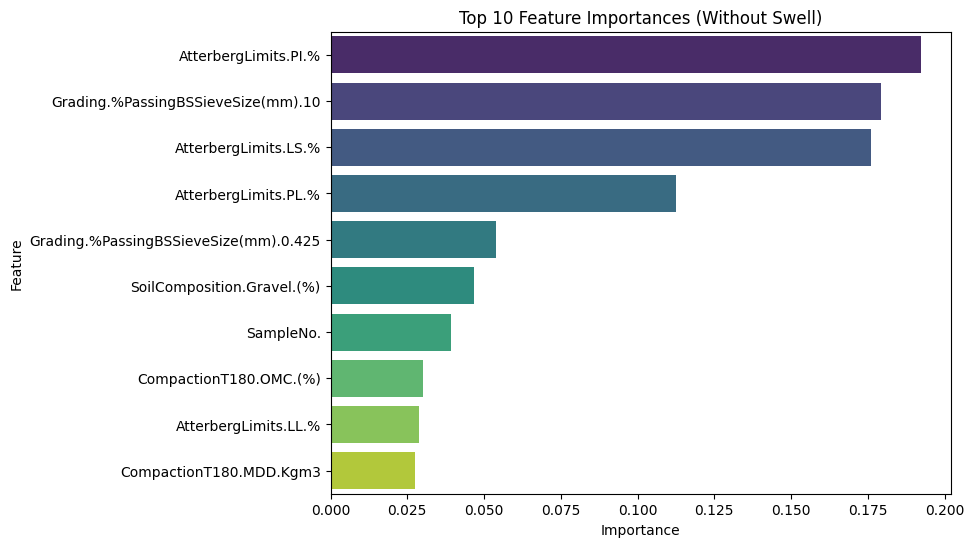

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

top_features = importances_no_swell.head(10)

plt.figure(figsize=(8,6))
sns.barplot(
    data=top_features,
    x="Importance",
    y="Feature",
    palette="viridis"
)
plt.title("Top 10 Feature Importances (Without Swell)")
plt.show()


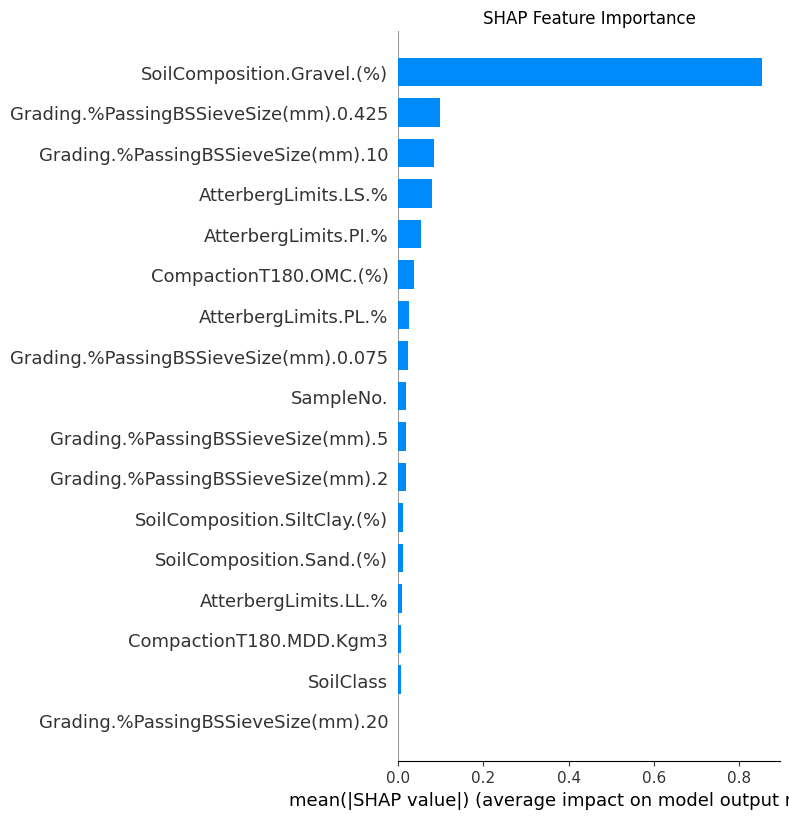

In [28]:
# Import SHAP
import shap

# Create a new cell for SHAP analysis
# Create a SHAP explainer for the RandomForest model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set (use a smaller sample if dataset is large)
sample_size = min(100, X_test_nd.shape[0])  # Use at most 100 samples for speed
sample_indices = np.random.choice(X_test_nd.shape[0], sample_size, replace=False)
X_sample = X_test_nd.iloc[sample_indices]

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Create a summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()